# Classification Notebook

In [2]:
%pylab inline
import kagglehub
import pylab
import sklearn
import pandas as pd
from sklearn.utils import Bunch
from scipy.io import loadmat
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight


# Cybersecurity data
path = kagglehub.dataset_download("atharvasoundankar/global-cybersecurity-threats-2015-2024")

print("Path to dataset files:", path)

# Load the dataset and preview the first few rows
files = os.listdir(path)
print("Files in dataset folder:", files)
file_path = os.path.join(path, files[0])
df = pd.read_csv(file_path)
df.head()

# Clean Data and ensure no missing values
df.info()
df.isnull().sum()

# Create new security threat level, group based on attack frequency
industry_threats = df.groupby(['Year', 'Target Industry']).size().reset_index(name='AttackCount')
# to find threat levels per industry, count total number of threats per industry
# then define different level levels
def label_threat_level(count):
    if count <= 50:
        return 'Low'
    elif count <= 200:
        return 'Medium'
    else:
        return 'High'

industry_threats['ThreatLevel'] = industry_threats['AttackCount'].apply(label_threat_level)
industry_threats.head()

# Merge labeled data back into original DataFrame
df = df.merge(industry_threats[['Year', 'Target Industry', 'ThreatLevel']], on=['Year', 'Target Industry'], how='left')
df.head()

Populating the interactive namespace from numpy and matplotlib


100%|██████████| 47.0k/47.0k [00:00<00:00, 4.26MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/atharvasoundankar/global-cybersecurity-threats-2015-2024/versions/1
Files in dataset folder: ['Global_Cybersecurity_Threats_2015-2024.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              3000 non-null   object 
 1   Year                                 3000 non-null   int64  
 2   Attack Type                          3000 non-null   object 
 3   Target Industry                      3000 non-null   object 
 4   Financial Loss (in Million $)        3000 non-null   float64
 5   Number of Affected Users             3000 non-null   int64  
 6   Attack Source                        3000 non-null   object 
 7   Security Vulnerability Type          3000 non-null   object 
 8   Defense Mecha

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours),ThreatLevel
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63,Low
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71,Low
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20,Medium
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7,Low
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68,Low


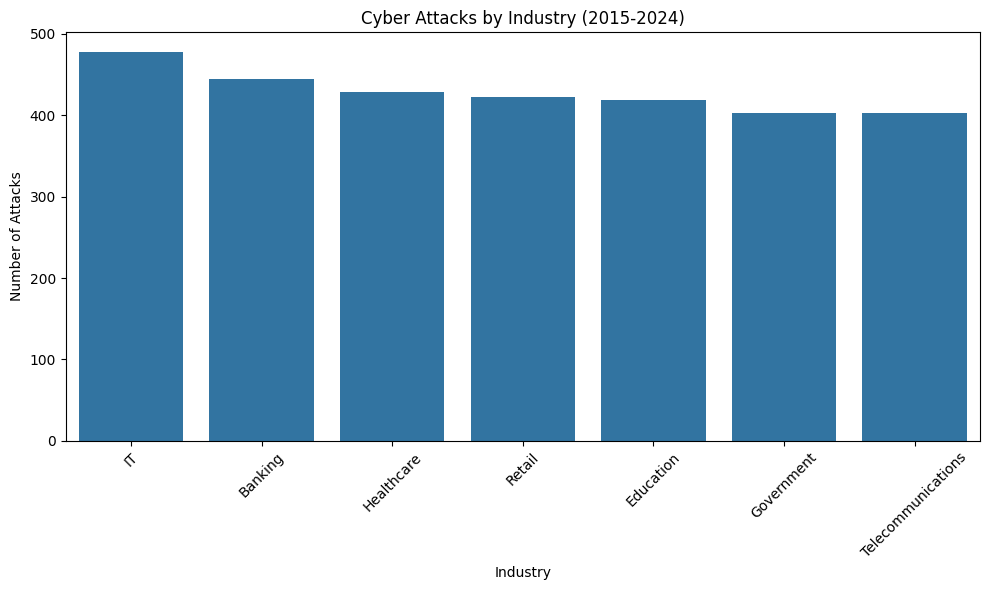

In [ ]:
# Bar chart: Attacks per industry
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Target Industry', order=df['Target Industry'].value_counts().index)
plt.title('Cyber Attacks by Industry (2015-2024)')
plt.xlabel('Industry')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('attacks_by_industry.png')
plt.show()

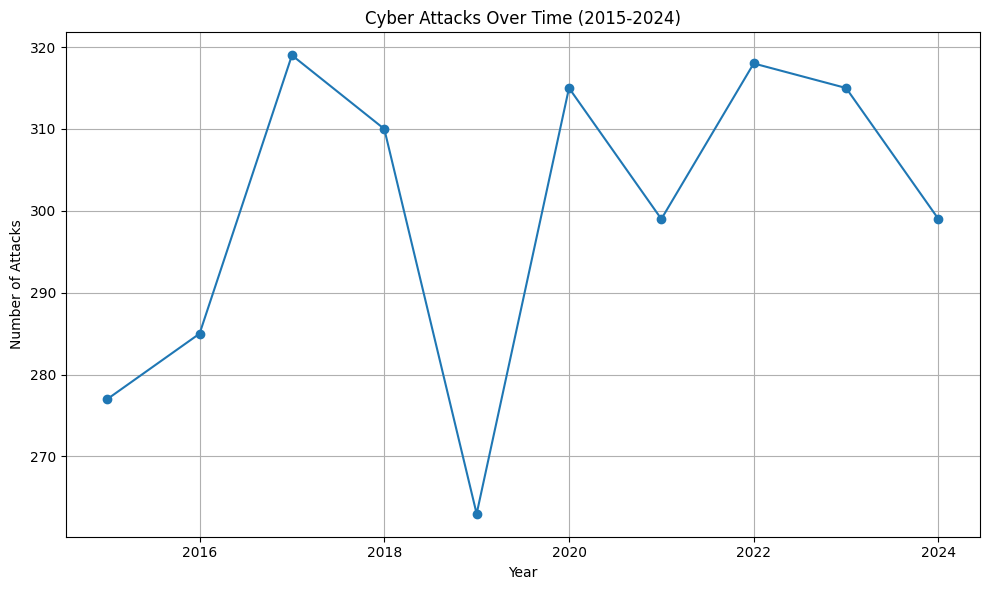

In [ ]:
# Line plot: Attacks over years
attacks_by_year = df.groupby('Year').size()
plt.figure(figsize=(10, 6))
attacks_by_year.plot(kind='line', marker='o')
plt.title('Cyber Attacks Over Time (2015-2024)')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.grid(True)
plt.tight_layout()
plt.savefig('attacks_over_time.png')
plt.show()

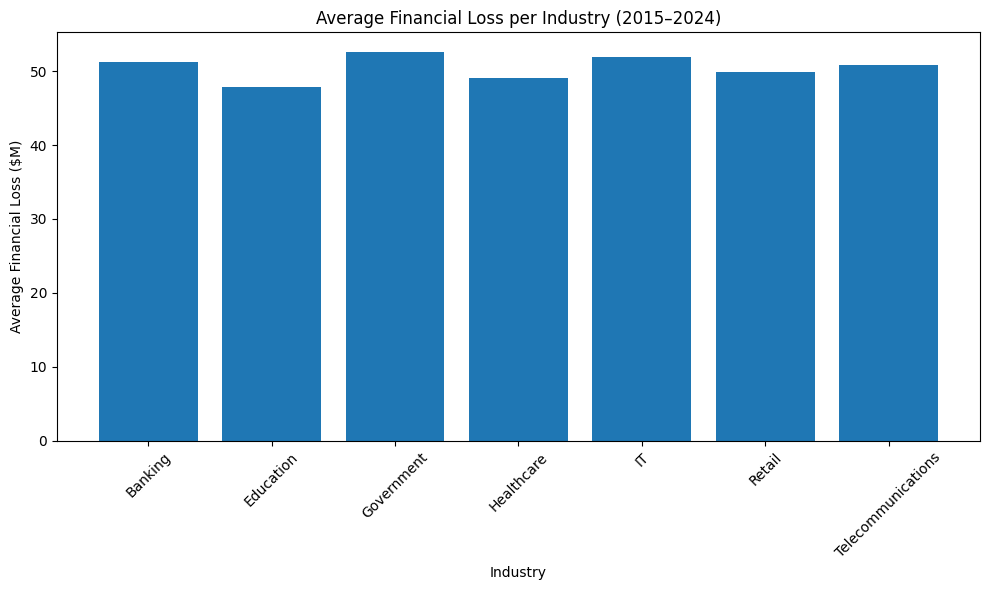

In [ ]:
# Bar chart: Average Financial Loss per Indistry
avg_loss = (
    df.groupby('Target Industry')['Financial Loss (in Million $)'].mean()
)
plt.figure(figsize=(10, 6))
plt.bar(avg_loss.index, avg_loss.values)
plt.title('Average Financial Loss per Industry (2015–2024)')
plt.xlabel('Industry')
plt.ylabel('Average Financial Loss ($M)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('attacks_by_industry.png')
plt.show()

In [3]:
# One-hot encoding for categorical features (Attack Type, Security Vulnerability Type, ThreatLevel)
df_encoded = pd.get_dummies(df, columns=['Attack Type', 'Security Vulnerability Type', 'ThreatLevel'], prefix=['Attack', 'Vuln', 'Threat'])

# Z-score normalization for numerical features (Financial Loss, Number of Affected Users)
scaler = StandardScaler()
df_encoded[['Financial_Loss_scaled', 'Affected_Users_scaled']] = scaler.fit_transform(
    df_encoded[['Financial Loss (in Million $)', 'Number of Affected Users']]
)

# Compute class weights for imbalanced Target Industry
classes = df_encoded['Target Industry'].unique()
class_weights = compute_class_weight('balanced', classes=classes, y=df_encoded['Target Industry'])
class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights for Target Industry:", class_weight_dict)

Class Weights for Target Industry: {'Education': np.float64(1.0228435049437437), 'Retail': np.float64(1.0131712259371835), 'IT': np.float64(0.8965929468021518), 'Telecommunications': np.float64(1.0634526763559022), 'Government': np.float64(1.0634526763559022), 'Banking': np.float64(0.9630818619582665), 'Healthcare': np.float64(0.999000999000999)}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results:
Macro F1-Score: 0.18619106058251972
Macro AUC-ROC (OvR): 0.5753036567117619


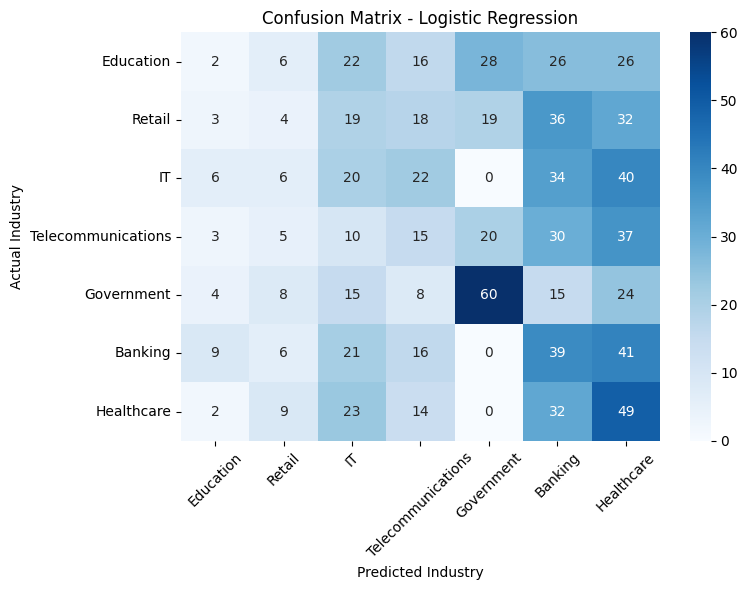

In [4]:
# Prepare features and target
X = df_encoded.drop(columns=['Target Industry', 'Country', 'Attack Source',
                           'Defense Mechanism Used', 'Incident Resolution Time (in Hours)',
                           'Financial Loss (in Million $)', 'Number of Affected Users'])
y = df_encoded['Target Industry']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Logistic Regression
log_reg = LogisticRegression(multi_class='multinomial', class_weight=class_weight_dict, max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions and metrics
y_pred = log_reg.predict(X_test)
print("Logistic Regression Results:")
print("Macro F1-Score:", f1_score(y_test, y_pred, average='macro'))
print("Macro AUC-ROC (OvR):", roc_auc_score(y_test, log_reg.predict_proba(X_test), multi_class='ovr'))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Industry')
plt.ylabel('Actual Industry')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('confusion_matrix_logreg.png')
plt.show()